In [1]:
# import glob # For getting file names
import matplotlib.pyplot as plt
# import numpy as np
# import os
# import pickle
# import seaborn as sns
# # import torch

# from collections import Counter
# # from gap_statistic import OptimalK
# from scipy import stats, cluster
# from sklearn.cluster import KMeans
# # from yellowbrick.cluster import KElbowVisualizer

# from utils.clustering_utils import *
# from utils.conformal_utils import *
from utils.experiment_utils import *

%load_ext autoreload
%autoreload 2

First run `sh run_heatmap_experiments.sh`

In [2]:
# Plot settings
sns.set_style(style='white', rc={'axes.spines.right': False, 'axes.spines.top': False})
sns.set_palette('pastel')
sns.set_context('paper')

In [3]:
frac_clustering_list = [.1,.2,.3,.4,.5,.6,.7,.8,.9]
num_clusters_list = [2, 3, 4, 5, 6, 8, 10, 15, 20, 50]
score_function_list = ['softmax', 'APS', 'RAPS']
n_list = [10, 20, 50, 75]

In [4]:
save_folder = f'.cache/paper/heatmaps/imagenet/'

.cache/paper/heatmaps/imagenet/frac=.1_numclusters=2/imagenet/random_calset/n_totalcal=10/score=softmax
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=3/imagenet/random_calset/n_totalcal=10/score=softmax
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=4/imagenet/random_calset/n_totalcal=10/score=softmax
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=5/imagenet/random_calset/n_totalcal=10/score=softmax
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=6/imagenet/random_calset/n_totalcal=10/score=softmax
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=8/imagenet/random_calset/n_totalcal=10/score=softmax
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=10/imagenet/random_calset/n_totalcal=10/score=softmax
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=15/imagenet/random_calset/n_totalcal=1

.cache/paper/heatmaps/imagenet/frac=.7_numclusters=5/imagenet/random_calset/n_totalcal=10/score=softmax
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.7_numclusters=6/imagenet/random_calset/n_totalcal=10/score=softmax
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.7_numclusters=8/imagenet/random_calset/n_totalcal=10/score=softmax
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.7_numclusters=10/imagenet/random_calset/n_totalcal=10/score=softmax
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.7_numclusters=15/imagenet/random_calset/n_totalcal=10/score=softmax
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.7_numclusters=20/imagenet/random_calset/n_totalcal=10/score=softmax
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.7_numclusters=50/imagenet/random_calset/n_totalcal=10/score=softmax
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.8_numclusters=2/imagenet/random_calset/n_totalcal

.cache/paper/heatmaps/imagenet/frac=.6_numclusters=10/imagenet/random_calset/n_totalcal=10/score=APS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.6_numclusters=15/imagenet/random_calset/n_totalcal=10/score=APS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.6_numclusters=20/imagenet/random_calset/n_totalcal=10/score=APS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.6_numclusters=50/imagenet/random_calset/n_totalcal=10/score=APS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.7_numclusters=2/imagenet/random_calset/n_totalcal=10/score=APS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.7_numclusters=3/imagenet/random_calset/n_totalcal=10/score=APS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.7_numclusters=4/imagenet/random_calset/n_totalcal=10/score=APS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.7_numclusters=5/imagenet/random_calset/n_totalcal=10/score=APS
Number of seed

.cache/paper/heatmaps/imagenet/frac=.5_numclusters=2/imagenet/random_calset/n_totalcal=10/score=RAPS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.5_numclusters=3/imagenet/random_calset/n_totalcal=10/score=RAPS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.5_numclusters=4/imagenet/random_calset/n_totalcal=10/score=RAPS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.5_numclusters=5/imagenet/random_calset/n_totalcal=10/score=RAPS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.5_numclusters=6/imagenet/random_calset/n_totalcal=10/score=RAPS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.5_numclusters=8/imagenet/random_calset/n_totalcal=10/score=RAPS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.5_numclusters=10/imagenet/random_calset/n_totalcal=10/score=RAPS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.5_numclusters=15/imagenet/random_calset/n_totalcal=10/score=RAPS
Number o

.cache/paper/heatmaps/imagenet/frac=.2_numclusters=20/imagenet/random_calset/n_totalcal=20/score=softmax
Number of seeds found: 7
.cache/paper/heatmaps/imagenet/frac=.2_numclusters=50/imagenet/random_calset/n_totalcal=20/score=softmax
Number of seeds found: 7
.cache/paper/heatmaps/imagenet/frac=.3_numclusters=2/imagenet/random_calset/n_totalcal=20/score=softmax
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.3_numclusters=3/imagenet/random_calset/n_totalcal=20/score=softmax
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.3_numclusters=4/imagenet/random_calset/n_totalcal=20/score=softmax
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.3_numclusters=5/imagenet/random_calset/n_totalcal=20/score=softmax
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.3_numclusters=6/imagenet/random_calset/n_totalcal=20/score=softmax
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.3_numclusters=8/imagenet/random_calset/n_totalcal=20/

.cache/paper/heatmaps/imagenet/frac=.1_numclusters=2/imagenet/random_calset/n_totalcal=20/score=APS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=3/imagenet/random_calset/n_totalcal=20/score=APS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=4/imagenet/random_calset/n_totalcal=20/score=APS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=5/imagenet/random_calset/n_totalcal=20/score=APS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=6/imagenet/random_calset/n_totalcal=20/score=APS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=8/imagenet/random_calset/n_totalcal=20/score=APS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=10/imagenet/random_calset/n_totalcal=20/score=APS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=15/imagenet/random_calset/n_totalcal=20/score=APS
Number of seeds 

.cache/paper/heatmaps/imagenet/frac=.7_numclusters=8/imagenet/random_calset/n_totalcal=20/score=APS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.7_numclusters=10/imagenet/random_calset/n_totalcal=20/score=APS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.7_numclusters=15/imagenet/random_calset/n_totalcal=20/score=APS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.7_numclusters=20/imagenet/random_calset/n_totalcal=20/score=APS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.7_numclusters=50/imagenet/random_calset/n_totalcal=20/score=APS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.8_numclusters=2/imagenet/random_calset/n_totalcal=20/score=APS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.8_numclusters=3/imagenet/random_calset/n_totalcal=20/score=APS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.8_numclusters=4/imagenet/random_calset/n_totalcal=20/score=APS
Number of seed

.cache/paper/heatmaps/imagenet/frac=.5_numclusters=6/imagenet/random_calset/n_totalcal=20/score=RAPS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.5_numclusters=8/imagenet/random_calset/n_totalcal=20/score=RAPS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.5_numclusters=10/imagenet/random_calset/n_totalcal=20/score=RAPS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.5_numclusters=15/imagenet/random_calset/n_totalcal=20/score=RAPS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.5_numclusters=20/imagenet/random_calset/n_totalcal=20/score=RAPS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.5_numclusters=50/imagenet/random_calset/n_totalcal=20/score=RAPS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.6_numclusters=2/imagenet/random_calset/n_totalcal=20/score=RAPS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.6_numclusters=3/imagenet/random_calset/n_totalcal=20/score=RAPS
Number

.cache/paper/heatmaps/imagenet/frac=.3_numclusters=6/imagenet/random_calset/n_totalcal=50/score=softmax
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.3_numclusters=8/imagenet/random_calset/n_totalcal=50/score=softmax
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.3_numclusters=10/imagenet/random_calset/n_totalcal=50/score=softmax
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.3_numclusters=15/imagenet/random_calset/n_totalcal=50/score=softmax
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.3_numclusters=20/imagenet/random_calset/n_totalcal=50/score=softmax
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.3_numclusters=50/imagenet/random_calset/n_totalcal=50/score=softmax
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.4_numclusters=2/imagenet/random_calset/n_totalcal=50/score=softmax
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.4_numclusters=3/imagenet/random_calset/n_totalcal

.cache/paper/heatmaps/imagenet/frac=.1_numclusters=2/imagenet/random_calset/n_totalcal=50/score=APS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=3/imagenet/random_calset/n_totalcal=50/score=APS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=4/imagenet/random_calset/n_totalcal=50/score=APS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=5/imagenet/random_calset/n_totalcal=50/score=APS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=6/imagenet/random_calset/n_totalcal=50/score=APS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=8/imagenet/random_calset/n_totalcal=50/score=APS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=10/imagenet/random_calset/n_totalcal=50/score=APS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=15/imagenet/random_calset/n_totalcal=50/score=APS
Number of seeds 

.cache/paper/heatmaps/imagenet/frac=.1_numclusters=2/imagenet/random_calset/n_totalcal=50/score=RAPS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=3/imagenet/random_calset/n_totalcal=50/score=RAPS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=4/imagenet/random_calset/n_totalcal=50/score=RAPS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=5/imagenet/random_calset/n_totalcal=50/score=RAPS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=6/imagenet/random_calset/n_totalcal=50/score=RAPS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=8/imagenet/random_calset/n_totalcal=50/score=RAPS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=10/imagenet/random_calset/n_totalcal=50/score=RAPS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=15/imagenet/random_calset/n_totalcal=50/score=RAPS
Number o

.cache/paper/heatmaps/imagenet/frac=.7_numclusters=20/imagenet/random_calset/n_totalcal=50/score=RAPS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.7_numclusters=50/imagenet/random_calset/n_totalcal=50/score=RAPS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.8_numclusters=2/imagenet/random_calset/n_totalcal=50/score=RAPS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.8_numclusters=3/imagenet/random_calset/n_totalcal=50/score=RAPS
Number of seeds found: 10
.cache/paper/heatmaps/imagenet/frac=.8_numclusters=4/imagenet/random_calset/n_totalcal=50/score=RAPS
Number of seeds found: 0
.cache/paper/heatmaps/imagenet/frac=.8_numclusters=5/imagenet/random_calset/n_totalcal=50/score=RAPS
Number of seeds found: 0
.cache/paper/heatmaps/imagenet/frac=.8_numclusters=6/imagenet/random_calset/n_totalcal=50/score=RAPS
Number of seeds found: 0
.cache/paper/heatmaps/imagenet/frac=.8_numclusters=8/imagenet/random_calset/n_totalcal=50/score=RAPS
Number of s

.cache/paper/heatmaps/imagenet/frac=.1_numclusters=2/imagenet/random_calset/n_totalcal=75/score=APS
Number of seeds found: 0
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=3/imagenet/random_calset/n_totalcal=75/score=APS
Number of seeds found: 0
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=4/imagenet/random_calset/n_totalcal=75/score=APS
Number of seeds found: 0
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=5/imagenet/random_calset/n_totalcal=75/score=APS
Number of seeds found: 0
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=6/imagenet/random_calset/n_totalcal=75/score=APS
Number of seeds found: 0
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=8/imagenet/random_calset/n_totalcal=75/score=APS
Number of seeds found: 0
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=10/imagenet/random_calset/n_totalcal=75/score=APS
Number of seeds found: 0
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=15/imagenet/random_calset/n_totalcal=75/score=APS
Number of seeds found: 

.cache/paper/heatmaps/imagenet/frac=.1_numclusters=2/imagenet/random_calset/n_totalcal=75/score=RAPS
Number of seeds found: 0
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=3/imagenet/random_calset/n_totalcal=75/score=RAPS
Number of seeds found: 0
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=4/imagenet/random_calset/n_totalcal=75/score=RAPS
Number of seeds found: 0
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=5/imagenet/random_calset/n_totalcal=75/score=RAPS
Number of seeds found: 0
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=6/imagenet/random_calset/n_totalcal=75/score=RAPS
Number of seeds found: 0
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=8/imagenet/random_calset/n_totalcal=75/score=RAPS
Number of seeds found: 0
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=10/imagenet/random_calset/n_totalcal=75/score=RAPS
Number of seeds found: 0
.cache/paper/heatmaps/imagenet/frac=.1_numclusters=15/imagenet/random_calset/n_totalcal=75/score=RAPS
Number of seeds

/tmp/ipykernel_2212602/3589869238.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


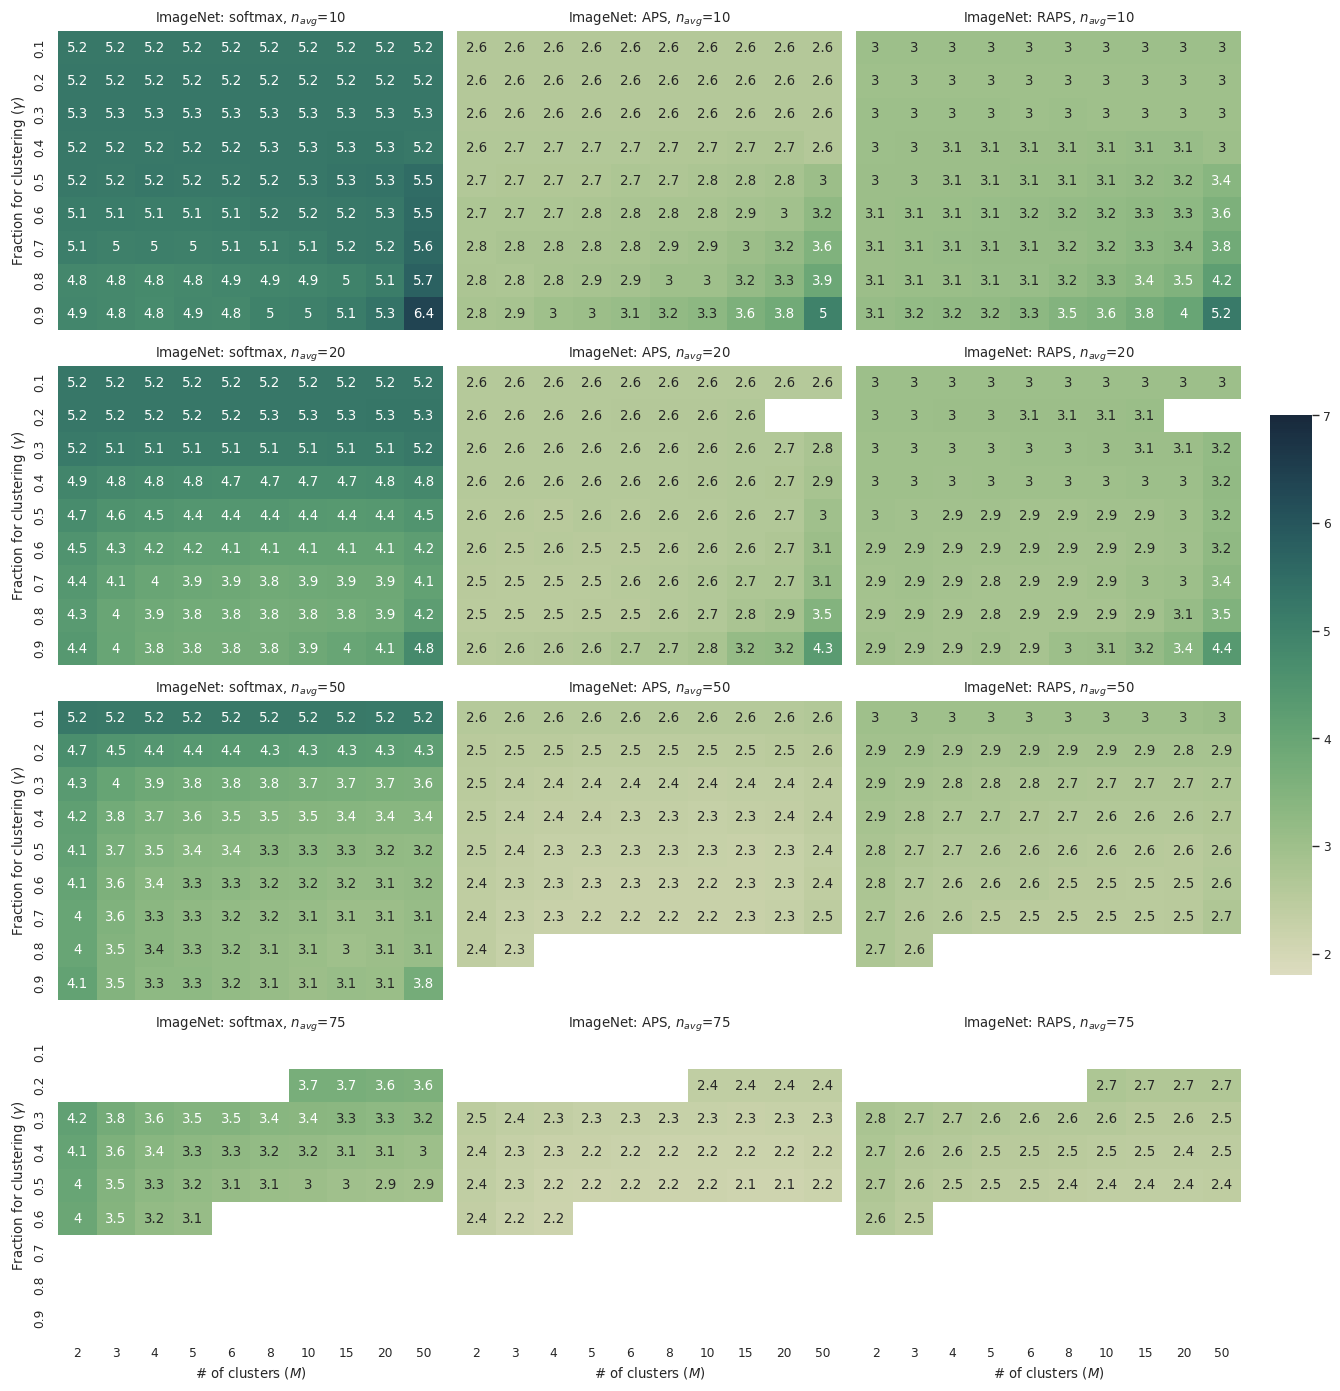

In [16]:
nrows = len(n_list)
ncols = len(score_function_list)
fig, axs = plt.subplots(nrows, ncols, figsize=(14,14), sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for row, n in enumerate(n_list): 
    for col, score_function in enumerate(score_function_list):
        
        means = np.zeros((len(frac_clustering_list), len(num_clusters_list)))
        ses = np.zeros(means.shape)
        
        for i, frac_clustering in enumerate(frac_clustering_list):
            for j, num_clusters in enumerate(num_clusters_list):
                curr_folder = f'.cache/paper/heatmaps/imagenet/frac={str(frac_clustering).replace("0.", ".")}_numclusters={num_clusters}'
                df = get_metric_df('imagenet', 'random', 'class_cov_gap', 
                                  score_function,
                                  method_list = ['cluster_random'],
                                  n_list = [n],
                                  save_folder=curr_folder)

                means[i,j] = df['class_cov_gap_mean']['cluster_random'][0]
                ses[i,j] = df['class_cov_gap_se']['cluster_random'][0]
         
#         fig, ax = plt.subplots(figsize=(8,5))
        plt_labels = np.array([[f'{means[i,j]:.2f} ({ses[i,j]:.2f})' for j in range(means.shape[1])] for i in range(means.shape[0])])
        ax = sns.heatmap(means, 
                         ax=axs[row][col],
                         annot=True,
#                          annot=plt_labels,
#                          fmt = '',
                         vmin=1.8, vmax=7, # OPTIONAL: adjust these for consistency between plots
#                          cbar=(i==0 and j==0),
                         cbar_ax=cbar_ax, #if i==0 and j==0 else None,
                         cmap=sns.cubehelix_palette(rot=-.6, as_cmap=True))
#                          cmap=sns.color_palette("cubehelix", as_cmap=True))
        ax.set_title(f'ImageNet: {score_function}, $n_{{avg}}$={n}')
        ax.set_ylabel(f"Fraction for clustering ($\\gamma$)" if col == 0 else None)
        ax.set_xlabel(f'# of clusters ($M$)' if row == nrows -1 else None)
#         ax.set(title=f'{title_prefix}',
#                ylabel=, 
#                xlabel="# of clusters ($M$)" if i == nrows -1 else None)
        ax.set_yticklabels(frac_clustering_list)
        ax.set_xticklabels(num_clusters_list)

fig.tight_layout(rect=[0, 0, .9, 1])
plt.show()

        

In [6]:
f'$n_{{\\text{{avg}}}}$={n}'

'$n_{\\text{avg}}$=75'

## Compute chosen clustering params
and see where they fall on the heatmap

In [7]:
softmax_scores, labels = load_dataset('imagenet')
num_classes = softmax_scores.shape[1]

softmax_scores shape: (1153051, 1000)


In [8]:
alpha = .1

seeds = np.arange(10)
for n in [10, 20, 50, 75]: 
    print(f'n={n}')
    for seed in seeds:
        _, totalcal_labels, _, _ = random_split(softmax_scores, labels, n, seed=seed)
        
        cts_dict = Counter(totalcal_labels)
        cts = [cts_dict.get(k, 0) for k in range(num_classes)]
        n_min = min(cts)
        n_thresh = get_quantile_threshold(alpha) 
        n_min = max(n_min, n_thresh) # Classes with fewer than n_thresh examples will be excluded from clustering
        num_remaining_classes = np.sum(np.array(list(cts)) >= n_min)

        n_clustering, num_clusters = get_clustering_parameters(num_remaining_classes, n_min)
        frac_clustering = n_clustering / n_min
        print(f'   frac_clustering={frac_clustering}, num_clusters={num_clusters}')

n=10
   frac_clustering=0.8888888888888888, num_clusters=4
   frac_clustering=0.8888888888888888, num_clusters=4
   frac_clustering=0.8888888888888888, num_clusters=4
   frac_clustering=0.8888888888888888, num_clusters=4
   frac_clustering=0.8888888888888888, num_clusters=4
   frac_clustering=0.8888888888888888, num_clusters=4
   frac_clustering=0.8888888888888888, num_clusters=4
   frac_clustering=0.8888888888888888, num_clusters=4
   frac_clustering=0.8888888888888888, num_clusters=4
   frac_clustering=0.8888888888888888, num_clusters=4
n=20
   frac_clustering=0.8888888888888888, num_clusters=4
   frac_clustering=0.8888888888888888, num_clusters=4
   frac_clustering=0.8888888888888888, num_clusters=4
   frac_clustering=0.8888888888888888, num_clusters=4
   frac_clustering=0.8888888888888888, num_clusters=4
   frac_clustering=0.8888888888888888, num_clusters=4
   frac_clustering=0.8888888888888888, num_clusters=4
   frac_clustering=0.8888888888888888, num_clusters=4
   frac_clustering

In [9]:
alpha = .1

seeds = np.arange(10)
for n in [10, 20, 50, 75]: 
    print(f'n={n}')
    for seed in seeds:
        _, totalcal_labels, _, _ = random_split(softmax_scores, labels, n, seed=seed)
        
        cts_dict = Counter(totalcal_labels)
        cts = [cts_dict.get(k, 0) for k in range(num_classes)]
        n_min = min(cts)
        n_thresh = get_quantile_threshold(alpha) 
        n_min = max(n_min, n_thresh) # Classes with fewer than n_thresh examples will be excluded from clustering
        num_remaining_classes = np.sum(np.array(list(cts)) >= n_min)

        n_clustering, num_clusters = get_clustering_parameters(num_remaining_classes, n_min)
        print(f'   n_clustering={n_clustering}, num_clusters={num_clusters}')

n=10
   n_clustering=8, num_clusters=4
   n_clustering=8, num_clusters=4
   n_clustering=8, num_clusters=4
   n_clustering=8, num_clusters=4
   n_clustering=8, num_clusters=4
   n_clustering=8, num_clusters=4
   n_clustering=8, num_clusters=4
   n_clustering=8, num_clusters=4
   n_clustering=8, num_clusters=4
   n_clustering=8, num_clusters=4
n=20
   n_clustering=8, num_clusters=4
   n_clustering=8, num_clusters=4
   n_clustering=8, num_clusters=4
   n_clustering=8, num_clusters=4
   n_clustering=8, num_clusters=4
   n_clustering=8, num_clusters=4
   n_clustering=8, num_clusters=4
   n_clustering=8, num_clusters=4
   n_clustering=8, num_clusters=4
   n_clustering=8, num_clusters=4
n=50
   n_clustering=22, num_clusters=11
   n_clustering=21, num_clusters=10
   n_clustering=14, num_clusters=7
   n_clustering=23, num_clusters=11
   n_clustering=23, num_clusters=11
   n_clustering=21, num_clusters=10
   n_clustering=21, num_clusters=10
   n_clustering=17, num_clusters=8
   n_clustering=17,

In [10]:
# def generate_n_clustering_list(rarest_class_ct):
#     '''
#     Generate candidate n_clustering values 
#     '''
#     n_clustering_list = (np.array([.3, .5, .7, .9]) * rarest_class_ct).astype(np.int32)
    
#     return n_clustering_list

# def generate_num_clusters_list(num_classes):
#     '''
#     Generate candidate num_clusters values 
#     '''
#     # List of possible numbers of clusters (1-10, then grid of 5 points through 10% of num_classes)
#     grid1 = np.arange(1, 11, dtype=int)
#     grid2 = np.linspace(10, np.ceil(.1 * num_classes), 5, dtype=int) # Removed a +1 here, so might want to reun
#     num_clusters_list = np.unique(np.concatenate((grid1, grid2)))
    
#     return num_clusters_list
    

# def compute_metrics_matrix(totalcal_scores_all, totalcal_labels,
#                         alpha,
#                         val_scores_all, val_labels, save_to=None,
#                         n_clustering_list=None, num_clusters_list=None):
#     '''
#     save_to: file path to save metrics matix to
#     '''
    
#     num_classes = totalcal_scores_all.shape[1]
    
#     if n_clustering_list is None:
#         rarest_class_ct = Counter(totalcal_labels).most_common()[-1][1]
#         n_clustering_list = generate_n_clustering_list(rarest_class_ct)
        
#     if num_clusters_list is None:
#         num_clusters_list = generate_num_clusters_list(num_classes)
        
        
#     print('n_clustering_list:', n_clustering_list)
#     print('num_clusters_list:', num_clusters_list)
        
#     results = {} # For storing coverage and set size metrics
    
#     for n_clustering in n_clustering_list:
#         results[f'n_clustering={n_clustering}'] = {}
            
#         for num_clusters in num_clusters_list: 
#             results[f'n_clustering={n_clustering}'][f'num_clusters={num_clusters}'] = {}
            
#             qhats, preds, coverage_metrics, set_size_metrics = clustered_conformal(totalcal_scores_all, totalcal_labels,
#                                                                 alpha,
#                                                                 n_clustering, num_clusters,
#                                                                 val_scores_all=val_scores_all, val_labels=val_labels)
    
#             results[f'n_clustering={n_clustering}'][f'num_clusters={num_clusters}']['coverage_metrics'] = coverage_metrics
#             results[f'n_clustering={n_clustering}'][f'num_clusters={num_clusters}']['set_size_metrics'] = set_size_metrics
    
#     if save_to is not None:
#         with open(save_to,'wb') as f:
#             pickle.dump(results, f)
#             print(f'Saved metrics matrix to {save_to}')
    
#     return results, n_clustering_list, num_clusters_list
    
# def compute_N_metrics_matrices(scores_all, labels, n_totalcal,
#                                 alpha, save_folder,
#                                 seeds=[0,1,2,3,4],
#                                 n_clustering_list=None, num_clusters_list=None):
#     '''
#     Computes N different metrics matrices, each for a different calibration/validation
#     split. N=len(seeds)
    
#     Inputs:
#         -seeds: list of ints used to seed the random data splitting
#     '''

#     os.makedirs(save_folder, exist_ok=True)

#     for seed in seeds:
#         totalcal_scores_all, totalcal_labels, val_scores_all, val_labels = split_X_and_y(scores_all, labels, n_totalcal, num_classes=num_classes, seed=seed)
        
#         print(f'Computing metrics matrix for seed={seed}...')
#         save_to = os.path.join(save_folder, f'seed={seed}_allmetrics.pkl')
#         compute_metrics_matrix(totalcal_scores_all, totalcal_labels,
#                                             alpha,
#                                             val_scores_all, val_labels, save_to=save_to,
#                                             n_clustering_list=None, num_clusters_list=None)
    
    
# def visualize_heatmaps(results, n_clustering_list, num_clusters_list, n_totalcal):
#     '''
#     Visualizes metric matrix using metrics from a single random seed. 
    
#     Input:
#         - results: 
#             metrics matrix, as produced by compute_metrics_matrix(), OR
#             list of metrics matrices
#     '''
    
#     cov_arr = [[results[f'n_clustering={n_clustering}'][f'num_clusters={num_clusters}']['coverage_metrics']['mean_class_cov_gap']
#                        for n_clustering in n_clustering_list] for num_clusters in num_clusters_list]
#     cov_arr = np.array(cov_arr) * 100

#     avg_set_size_arr = [[results[f'n_clustering={n_clustering}'][f'num_clusters={num_clusters}']['set_size_metrics']['mean']
#                        for n_clustering in n_clustering_list] for num_clusters in num_clusters_list]
#     # Can also make plots for set size quantiles

#     title_prefix = f'[{score_function}]'

#     ax = sns.heatmap(cov_arr, annot=True,
#                     cmap=sns.color_palette("viridis_r", as_cmap=True))
#     ax.set(title=f'{title_prefix} Average class coverage gap (%)',
#            xlabel=f"# of points used for clustering (out of {n_totalcal})", 
#            ylabel="# of clusters")
#     ax.set_xticklabels(n_clustering_list)
#     ax.set_yticklabels(num_clusters_list)
#     plt.show()

#     ax = sns.heatmap(avg_set_size_arr, annot=True,
#                      cmap=sns.color_palette("magma_r", as_cmap=True),
#                      vmax=40)
#     ax.set(title=f'{title_prefix} Average set size',
#            xlabel=f"# of points used for clustering (out of {n_totalcal})", 
#            ylabel="# of clusters")
#     ax.set_xticklabels(n_clustering_list)
#     ax.set_yticklabels(num_clusters_list)
#     plt.show()
    
# def visualize_heatmaps_with_SE(folder, n_clustering_list, num_clusters_list, n_totalcal):
#     '''
#     Visualizes metric matrix using metrics from multiple random seeds. Computes mean and
#     standard error across random seeds.
    
#     Input:
#         - folder: path to folder containing saved metric matrices, as produced by 
#         compute_metrics_matrix() All files in the folder that match "*.pkl" will be used. 

#     '''
    
#     file_names = sorted(glob.glob(os.path.join(folder, '*.pkl')))
# #     print('Files found:', file_names)
    
#     cov_arr_all = []
#     avg_set_size_arr_all = []
        
#     for pth in file_names:
#         with open(pth, 'rb') as f:
#             results = pickle.load(f)

#         cov_arr = [[results[f'n_clustering={n_clustering}'][f'num_clusters={num_clusters}']['coverage_metrics']['mean_class_cov_gap']
#                            for n_clustering in n_clustering_list] for num_clusters in num_clusters_list]
#         cov_arr = np.array(cov_arr) * 100

#         avg_set_size_arr = [[results[f'n_clustering={n_clustering}'][f'num_clusters={num_clusters}']['set_size_metrics']['mean']
#                        for n_clustering in n_clustering_list] for num_clusters in num_clusters_list]
    
#         cov_arr_all.append(cov_arr)
#         avg_set_size_arr_all.append(avg_set_size_arr)
    
#     cov_arr_all = np.array(cov_arr_all)
#     avg_set_size_arr_all = np.array(avg_set_size_arr_all)
    
#     title_prefix = f'[{score_function}]'
    
#     cov_mean = np.mean(cov_arr_all, axis=0)
#     cov_se = np.std(cov_arr_all, axis=0, ddof=1) # UPDATED
#     plt_labels = np.array([[f'{cov_mean[i,j]:.2f} ({cov_se[i,j]:.2f})' for j in range(cov_mean.shape[1])] for i in range(cov_mean.shape[0])])
#     ax = sns.heatmap(cov_mean, annot=plt_labels, fmt = '',
#                     vmin=1.8, vmax=7, # OPTIONAL: adjust these for consistency between plots
#                     cmap=sns.color_palette("viridis_r", as_cmap=True))
#     ax.set(title=f'{title_prefix} Class coverage gap as % (SE in parentheses)',
#            xlabel=f"# of points used for clustering (out of {n_totalcal})", 
#            ylabel="# of clusters")
#     ax.set_xticklabels(n_clustering_list)
#     ax.set_yticklabels(num_clusters_list)
#     plt.show()

#     # Plot average set size
#     size_mean = np.mean(avg_set_size_arr_all, axis=0)
#     size_se = np.std(avg_set_size_arr_all, axis=0, ddof=1) # UPDATED
#     plt_labels = np.array([[f'{size_mean[i,j]:.2f} ({size_se[i,j]:.2f})' for j in range(size_mean.shape[1])] for i in range(size_mean.shape[0])])
#     ax = sns.heatmap(size_mean, annot=plt_labels, fmt = '',
#                     vmin=37, vmax=60, # OPTIONAL: adjust these for consistency between plots
#                      cmap=sns.color_palette("magma_r", as_cmap=True))
#     ax.set(title=f'{title_prefix} Average set size (SE in parentheses)',
#            xlabel=f"# of points used for clustering (out of {n_totalcal})", 
#            ylabel="# of clusters")
#     ax.set_xticklabels(n_clustering_list)
#     ax.set_yticklabels(num_clusters_list)
#     plt.show()